In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize,root
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

# Define the experiment class

In [2]:
class MLE:
    def __init__(self,dim,alpha,sigma,df=1):
        self.alpha=alpha
        self.VaR=norm.ppf(alpha)
        refavar=np.array([alpha*(1-alpha),4*(alpha*(1-alpha))**2])/norm.pdf(self.VaR)**2
        print('Reference for a-var (direct, optimal): {}'.format(refavar))
        
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.oP=lambda x,VaR: self.T(x)*np.abs(1.0*(x[:,0]<VaR)-self.alpha)/(2*self.alpha*(1-self.alpha))
        self.iP=lambda x: mvt.pdf(x=x,loc=np.zeros(dim),shape=sigma**2,df=df)
        self.iS=lambda size: mvt.rvs(size=size,loc=np.zeros(dim),shape=sigma**2,df=df)
        
    def __estimate(self,S,W,name,asym=True):
        self.eVaR=quantile(S[:,0],W,self.alpha)
        err=self.eVaR-self.VaR
        if asym:
            w=W/np.sum(W)
            aVar=np.sum((w*((S[:,0]<=self.eVaR)-self.alpha))**2)*W.size
            aVar/=norm.pdf(self.VaR)**2
            aErr=np.sqrt(aVar/W.size)
            ESS=1/np.sum(w**2)
            print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}; ESS: {:.0f}/{}'\
                  .format(name,self.eVaR,err,aVar,aErr,ESS,W.size))
        else:
            print('{} est: {:.4f}; err: {:.4f}'.format(name,self.eVaR,err))
        
    def estimate_IS(self,size):
        S=self.iS(size)
        W=self.T(S)/self.iP(S)
        self.__estimate(S,W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,self.oP(X,self.VaR))
        ax.plot(x,P(X))
        if name=='nonparametric':
            one=np.zeros(self.dim)
            one[dim]=1
            rW=np.array([self.h(one*loc,loc) for loc in self.rS])
            rW=rW/rW.max()*P(np.zeros([1,self.dim]))[0]
            rWmeans=np.ones_like(rW)*rW.mean()

            ax.plot(x,self.mP(X))
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rWmeans)
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rW)
            ax.legend(['target','optimal proposal','nonparametric proposal',\
                       'mixture proposal','centers','centers with weight'])
        elif name=='regression':
            G=self.G(X)
            rPO=self.regO.coef_.dot(G)+self.regO.intercept_*P(X)
            rPL=self.regL.coef_.dot(G)+self.regL.intercept_*P(X)
            mid=int(x.size/2)
            print('regression ratios: ordinary {:.4f}, lasso {:.4f}'\
                  .format(self.T(X[mid])/rPO[mid],self.T(X[mid])/rPL[mid]))
            
            ax.plot(x,rPO)
            ax.plot(x,rPL)
            ax.legend(['target','optimal proposal','mixture proposal','ordinary regression','lasso regression'])
        else:
            ax.legend(['target','optimal proposal','{} proposal'.format(name)])
            
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size,ratio):
        S=self.iS(ratio*size)
        p=self.oP(S,self.eVaR)/self.iP(S)
        index=np.arange(S.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=S[choice]
        self.rSset=S[list(set(choice))]
        print('resampling rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,size,rate,bdwth='scott'):
        self.kde=sciKDE(self.rS.T,bw_method=bdwth)
        cov=self.kde.covariance_factor()*np.cov(self.rS.T)
        print('bdwth: {}'.format(np.round(np.sqrt(np.diag(cov)),2)))
        self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=cov)
        def G(x):
            tmp=np.array([self.h(x,loc) for loc in self.rSset])
            return tmp[1:]-tmp.mean(axis=0)

        self.G=G
        
        self.nP=lambda x: self.kde.pdf(x.T)
        self.nS=lambda size: self.kde.resample(size).T
        S=self.nS(size)
        W=self.T(S)/self.nP(S)
        self.__estimate(S,W,'NIS')
        
        self.mP=lambda x: (1-rate)*self.iP(x)+rate*self.nP(x)
        self.mS=lambda size: np.vstack([self.iS(size-round(rate*size)),self.nS(round(rate*size))])
        self.S=self.mS(size)
        W=self.T(self.S)/self.mP(self.S)
        self.__estimate(self.S,W,'MIS')
        
    def estimate_RIS(self,alpha,vif=False):
        X=(self.G(self.S)/self.mP(self.S)).T
        if vif:
            if X.shape[1]<=100:
                ind=np.arange(X.shape[1])
            else:
                ind=np.random.choice(np.arange(X.shape[1]),100,replace=False)

            tmp=np.hstack([X,np.ones([X.shape[0],1])])
            Vif=np.zeros(ind.size)
            for i in range(ind.size):
                Vif[i]=VIF(tmp,ind[i])

            print('VIF: (min {:.4f}, median {:.4f}, mean {:.4f}, max {:.4f}, [>5] {}/{})'\
                  .format(Vif.min(),np.median(Vif),Vif.mean(),Vif.max(),np.sum(Vif>5),Vif.size))
        
        y=self.T(self.S)/self.mP(self.S)
        self.regO=Linear().fit(X,y)
        self.regL=Lasso(alpha).fit(X,y)
        print('Ordinary R2: {:.4f}; Lasso R2: {:.4f}'.format(self.regO.score(X,y),self.regL.score(X,y)))
        
        W=y-X.dot(self.regO.coef_)
        self.__estimate(W,'RIS(Ord)')
        W=y-X.dot(self.regL.coef_)
        self.__estimate(W,'RIS(Las)')
    
    def estimate_MLE(self,opt=False):
        mP=self.mP(self.S)
        G=self.G(self.S)
        target=lambda zeta: -np.mean(np.log(mP+zeta.dot(G)))
        gradient=lambda zeta: -np.mean(G/(mP+zeta.dot(G)),axis=1)
        hessian=lambda zeta: (G/(mP+zeta.dot(G))**2).dot(G.T)/G.shape[1]
        zeta0=np.zeros(G.shape[0])
        grad0=gradient(zeta0)
        print('Reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=(G/mP).T
        XX=X-X.mean(axis=0)
        zeta1=np.linalg.solve(XX.T.dot(XX),X.sum(axis=0))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T(self.S)/mP)*(1-XX.dot(zeta1))
        self.__estimate(W,'RIS(The)',asym=False)
        W=self.T(self.S)/(mP+zeta1.dot(G))
        self.__estimate(W,'MLE(The)',asym=False)
        
        if opt:
            zeta=zeta1 if target(zeta1)!=np.nan else zeta0
            begin=dt.now()
            res=root(lambda zeta: (gradient(zeta),hessian(zeta)),zeta,method='lm',jac=True)
            end=dt.now()
            print()
            print('Optimization results (spent {} seconds):'.format((end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('Dist(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T(self.S)/(mP+zeta.dot(G))
                self.__estimate(W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

Reference for a-var (direct, optimal): [4.46556146 0.84845668]
IS est: -1.6350; err: 0.0098; a-var: 18.2993; a-err: 0.0135; ESS: 17813/100000


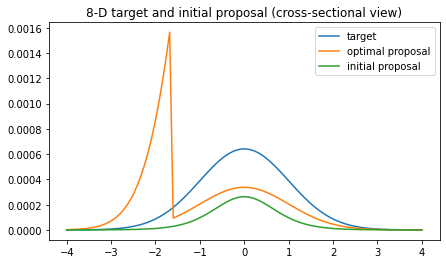

resampling rate: 880/1000
bdwth: [0.98 0.76 0.76 0.74 0.73 0.74 0.72 0.73]
NIS est: -1.6448; err: 0.0001; a-var: 3.3057; a-err: 0.0057; ESS: 22973/100000
MIS est: -1.6419; err: 0.0030; a-var: 2.5827; a-err: 0.0051; ESS: 29605/100000


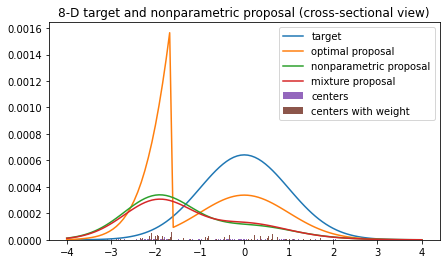

In [7]:
np.random.seed(19971107)
mle=MLE(dim=8,alpha=0.05,sigma=2,df=1)
size=100000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(1000,100)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')